# Maîtrise de la boîte à outils

In [2]:
from deap import base, creator, tools
import random
import numpy as np

In [ ]:
## Fitness de maximisation
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
## Création Classe Individu (ici est une liste)
creator.create("Individual", list, fitness=creator.FitnessMin)

## la toolbox
toolbox = base.Toolbox()

## 
toolbox.register("individual",
                 tools.initIterate,
                 creator.Individual, toolbox.indices)

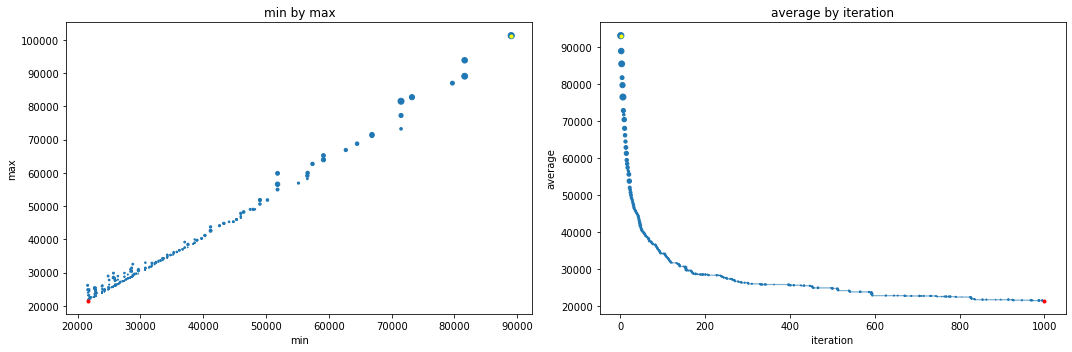

In [12]:
INDIVIDUAL_SIZE = NUMBER_OF_CITIES = 100
distances = np.zeros((NUMBER_OF_CITIES, NUMBER_OF_CITIES))
for city in range(NUMBER_OF_CITIES):
    cities = [ i for i in range(NUMBER_OF_CITIES) if not i == city ]
    for to_city in cities:
        distances[to_city][city] = \
            distances[city][to_city] = random.randint(50, 2000)




## Fitness minimisation
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
## Création Individu (ici est une liste)
creator.create("Individual", list, fitness=creator.FitnessMin)

## Création boite à outils
toolbox = base.Toolbox()

## outil générateur d'indices
toolbox.register("indices", \
                 random.sample, \
                 range(INDIVIDUAL_SIZE), 
                 INDIVIDUAL_SIZE)

## création d'un individu
toolbox.register("individual", \
                 tools.initIterate, \
                 creator.Individual, toolbox.indices)

## fonction pour créer la population
toolbox.register("population", \
                 tools.initRepeat, \
                 list, toolbox.individual)



## définition de l'évaluation (propre au problème)
def EVALUATE(individual):
    summation = 0
    start = individual[0]
    for i in range(1, len(individual)):
        end = individual[i]
        summation += distances[start][end]
        start = end
    return summation

## évaluation
toolbox.register("evaluate", EVALUATE)
## crossover
toolbox.register("mate", tools.cxOrdered)
## mutation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.01)
## selection
toolbox.register("select", tools.selTournament, tournsize=10)



class Runner:  
    def __init__(self, toolbox):
        self.toolbox = toolbox
        self.set_parameters(10, 5, 2)
        
    def set_parameters(self, population_size, iterations, n_matings):
        self.iterations = iterations
        self.population_size = population_size
        self.n_matings = n_matings
        
    def set_fitness(self, population):
        fitnesses = [ 
            (individual, self.toolbox.evaluate(individual)) 
            for individual in population 
        ]

        for individual, fitness in fitnesses:
            individual.fitness.values = (fitness,)
            
    def get_offspring(self, population):
        n = len(population)
        for _ in range(self.n_matings):
            i1, i2 = np.random.choice(range(n), size=2, replace=False)

            offspring1, offspring2 = \
                self.toolbox.mate(population[i1], population[i2])
            
            yield self.toolbox.mutate(offspring1)[0]
            yield self.toolbox.mutate(offspring2)[0]
    
    @staticmethod
    def pull_stats(population, iteration=1):
        fitnesses = [ individual.fitness.values[0] for individual in population ]
        return {
            'i': iteration,
            'mu': np.mean(fitnesses),
            'std': np.std(fitnesses),
            'max': np.max(fitnesses),
            'min': np.min(fitnesses)
        }  
    
    def Run(self):
        population = self.toolbox.population(n=self.population_size)
        self.set_fitness(population)
        
        stats = []
        for iteration in list(range(1, self.iterations + 1)):
            current_population = list(map(self.toolbox.clone, population))
            offspring = list(self.get_offspring(current_population))            
            for child in offspring:
                current_population.append(child)
            
            ## reset fitness,
            self.set_fitness(current_population)
            
            population[:] = self.toolbox.select(current_population, len(population))
            stats.append(
                Runner.pull_stats(population, iteration))
            
        return stats, population
    
    
    
    
POPULATION_SIZE = 200
N_ITERATIONS = 1000
N_MATINGS = 50

## Utilisation de la classe intermédiaire
a = Runner(toolbox)
a.set_parameters(POPULATION_SIZE, N_ITERATIONS, N_MATINGS)

## Lancement
stats, population = a.Run()




import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

_ = plt.scatter([ s['min'] for s in stats ], [ s['max'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])

_ = plt.title('min by max')
_ = plt.xlabel('min')
_ = plt.ylabel('max')

_ = plt.plot(stats[0]['min'], stats[0]['max'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['min'], stats[-1]['max'], marker='.', color='red')


plt.subplot(1,2,2)

_ = plt.scatter([ s['i'] for s in stats ], [ s['mu'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])

_ = plt.title('average by iteration')
_ = plt.xlabel('iteration')
_ = plt.ylabel('average')

_ = plt.plot(stats[0]['i'], stats[0]['mu'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['i'], stats[-1]['mu'], marker='.', color='red')

plt.tight_layout()
plt.show()

In [13]:
distances

array([[   0., 1741., 1202., ..., 1819., 1118., 1879.],
       [1741.,    0.,  185., ..., 1178., 1949., 1054.],
       [1202.,  185.,    0., ...,  539.,  477.,  122.],
       ...,
       [1819., 1178.,  539., ...,    0.,  507., 1931.],
       [1118., 1949.,  477., ...,  507.,    0., 1768.],
       [1879., 1054.,  122., ..., 1931., 1768.,    0.]])

In [11]:
for i in distances:
    print(i)

[   0. 1716. 1246.  270.  386.  106.  703.  717. 1622.  905.  457. 1139.
 1527.  776. 1800. 1842. 1071.  631.  257.  891. 1493. 1891.  183. 1548.
 1236.  140. 1475. 1037.  362.  262.   61.  917. 1818. 1598. 1595.  931.
  919.  139.  405. 1692. 1642.  743. 1367.  178. 1477. 1777.  747. 1951.
  829.  539. 1401. 1680. 1046. 1166. 1661. 1383. 1933.  876.  127.  787.
  648. 1563. 1286.  562. 1755. 1156. 1916.  350.  903.  470.  509. 1604.
 1206.  444.  654. 1055.  156.  491.  978.  888. 1875.  816. 1084.  888.
  125. 1113.   66. 1547. 1462. 1026.  542.  165.  587.  840. 1305.  842.
 1976.  330.  798.  979.]
[1716.    0. 1244. 1040.  203.  160.  376.  235.  949. 1183. 1481.  566.
  693.  294.  311.  547.  133.  268. 1169.  126. 1025. 1692. 1292. 1413.
  808. 1268. 1840. 1263. 1397. 1933. 1269.  321. 1235.  922. 1188.  852.
  347. 1781. 1111. 1383.  287.  945. 1073. 1838.  228. 1165.  871. 1206.
 1015.  647.  427.  929. 1023.  269.  746. 1365.  183.  207. 1738. 1462.
 1067.  228. 1322. 1250. 

[ 262. 1933.  767. 1089. 1131. 1139.  349.  382.  796. 1538.  333. 1254.
  776. 1513.  206. 1355.  374.  139.  682. 1128.  996.  864.  714.  424.
 1141. 1013.  136.  693. 1089.    0. 1959.  417. 1260. 1939. 1487. 1167.
  317.  628.  923.  946.  647.  304.  156. 1448. 1887. 1667.  409.  465.
 1652.  550.  941.  944.  144.  666.  603.  761.  632. 1876.  981. 1846.
 1562. 1629. 1174.  633. 1082.  881. 1715.  387. 1450. 1369. 1380. 1142.
  714.  511.  818. 1116.  594.  291. 1431.   65.  875.  406. 1451.  632.
 1729.  837. 1932. 1230.  249.  513. 1454. 1778. 1674.  138.  948.  600.
 1601. 1366. 1093. 1318.]
[  61. 1269.  483.  745. 1510.  657.  263.  190.  188. 1620.  738. 1918.
 1411.  869. 1363. 1302. 1372.  460. 1888.  154.  511. 1115.  957.  913.
  511. 1926.  804. 1850.  739. 1959.    0.  917.  422.  528.  529.  603.
 1837. 1631. 1698.   90. 1779.  666.  853. 1263.  854. 1748. 1583.   84.
 1489. 1244. 1328.  869.  297. 1224. 1858.  733. 1858. 1835.  729. 1163.
  158.  831.  910. 1801. 

[1604. 1135. 1593. 1650.  925. 1185. 1675. 1990.  935. 1551. 1473. 1350.
  166. 1830.   64. 1452.  852.   67. 1027. 1502. 1248.  842.  869.  258.
   70. 1121.  473. 1817.  602. 1142.  796.  120.  100. 1402. 1124.  335.
  259.  687.  238.  812. 1570. 1208.  204. 1242.  591.  253.  644. 1234.
  158.  887.  694. 1927. 1458. 1509.  830.  770. 1847. 1095.  518.  715.
 1289. 1096.  475. 1265. 1780. 1109. 1335. 1915.  627. 1886.  751.    0.
 1637.  567. 1165. 1532. 1968. 1023. 1107. 1582.  952.  678. 1087.  406.
  981.  947.   87.  162. 1706. 1562. 1664.  232.  486. 1411. 1384.  349.
  193.  483. 1073.  289.]
[1206. 1362.   92.  151.   84.  230. 1860. 1337. 1092. 1786.  526. 1068.
  156. 1047. 1118.  461. 1547.  468. 1508. 1572. 1607.  495. 1278.   58.
 1749. 1448.  226.  557. 1133.  714.  210. 1815.   90. 1918.  485. 1695.
 1481.  693.  177. 1042.  760. 1100.  102.  507. 1666. 1801. 1528.  103.
  764. 1162.   62. 1155.  245.  974.  817.  517. 1722. 1699.  152. 1826.
  415. 1731. 1701. 1989. 